In [1]:
import numpy as np
import torch
from torch import nn
import torchvision
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
from torchvision.models import resnet18
import time
# ! pip install git+https://github.com/davidbau/baukit
# ! pip install torchinfo tqdm matplotlib
# ! unzip -q flat_spectrograms.zip
# ! unzip -q train_val_test.zip

In [2]:
from baukit import show
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
train_path = "/scratch/monaghan.ad/data/train_val_test1/train" # "data/spectrograms/train"
val_path = "/scratch/monaghan.ad/data/train_val_test1/val"
# test_path = "mnist_4440/test"
# train_set = ImageFolder(train_path)
# print("Number of images in the training set =", len(train_set))

cuda


In [3]:
# idx = 4440
# item = train_set[idx]
# print(f"{idx}th item is a pair", item)

# img, label = train_set[idx]
# show(img)
# print(f"{label=} ({train_set.classes[label]})")

In [4]:
from torchvision.transforms import (
    RandomCrop,
    RandomHorizontalFlip,
    RandomVerticalFlip,
    RandomRotation,
    Normalize,
)
from torchvision.transforms import v2

img_size = 256

base_augs = [
    v2.ToTensor(),
    v2.ToDtype(torch.float32),
    v2.Grayscale(num_output_channels=1),
    v2.Resize((img_size, img_size)),
    v2.Normalize(mean=[0.1723], std=[0.1165]),  # note, these values are calculated from 10k image from the training set. This should likely be a learned parameter though because different images have different sound profiles
]

train_aug = transforms.Compose(
    [
        *base_augs,
        # v2.RandomRotation(5),
        v2.RandomCrop(size=256, padding=20),  # need to be weary of cutting off a lot of whales at the left side
    ]
)

/home/monaghan.ad/ml/lib/python3.11/site-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


In [5]:
from torchvision import transforms

class mapping_transform(object):
  def __init__(self, num_labels):
    self.num_labels = num_labels

  def __call__(self, labels):    
    # generate new random label
    # new_label = np.array([mapping[l] for l in labels])
    return mapping[labels]#new_label

mapping = {0: 0, 1: 0, 2: 1, 3: 3, 4: 0, 5: 2}

img_size = 256
train_set = torchvision.datasets.ImageFolder(
    train_path, 
    transform=train_aug,
    target_transform=mapping_transform(num_labels=4)#transforms.Lambda(lambda y: mapping_transform(y)),
)

val_set = torchvision.datasets.ImageFolder(
    val_path, 
    transform=transforms.Compose(base_augs),
    target_transform=mapping_transform(num_labels=4)#transforms.Lambda(lambda y: mapping_transform(y)),
)

train_set.targets = [mapping[t] for t in train_set.targets]
val_set.targets = [mapping[t] for t in val_set.targets]
train_set.classes = ["Background", "Fish", "Vessel", "Mn"]  # @Brandon seems like before you had Vessel at 3 and Mn at 2 but the labels were off, not sure
val_set.classes = ["Background", "Fish", "Vessel", "Mn"]

In [6]:
train_set.classes

['Background', 'Fish', 'Vessel', 'Mn']

In [7]:
val_set.classes

['Background', 'Fish', 'Vessel', 'Mn']

In [8]:
set(train_set.targets)

{0, 1, 2, 3}

In [9]:
img, label = train_set[1189]
len(train_set), len(val_set)
# now the image is a tensor
# img.resize((3, 256, 256))
# img#.shape
# torchvision.transforms.Resize((256, 256))(img)

(56954, 8136)

In [10]:
# # m = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True)
# summary(m, (1, 3, 256, 256))

In [11]:
train_loader = torch.utils.data.DataLoader(
    train_set,
    batch_size=400,
    shuffle=True,
    num_workers=24,
    pin_memory=True,
    
)

val_loader = torch.utils.data.DataLoader(
    val_set,
    batch_size=400,
    shuffle=True,
    num_workers=24,
    pin_memory=True,
)

In [12]:
images, labels = next(train_loader.__iter__())
print(f"{images.shape=}, {labels.shape=}")

images.shape=torch.Size([400, 1, 256, 256]), labels.shape=torch.Size([400])


In [13]:
# ## Some helper functions to view network parameters
from torchinfo import summary

def view_network_shapes(model, input_shape):
    print(summary(model, input_size=input_shape))

def view_network_parameters(model):
    # Visualise the number of parameters
    tensor_list = list(model.state_dict().items())
    total_parameters = 0
    print("Model Summary\n")
    for layer_tensor_name, tensor in tensor_list:
        total_parameters += int(torch.numel(tensor))
        print("{}: {} elements".format(layer_tensor_name, torch.numel(tensor)))
    print(f"\nTotal Trainable Parameters: {total_parameters}!")

In [14]:
model = resnet18()
model.conv1 = nn.Conv2d(1, 64, kernel_size=(7,7), stride=(2,2), padding=(3,3), bias=False)
model.fc = nn.Linear(512, 4, bias=True)
model = model.to(device)
view_network_shapes(model, img[None].shape)

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [1, 4]                    --
├─Conv2d: 1-1                            [1, 64, 128, 128]         3,136
├─BatchNorm2d: 1-2                       [1, 64, 128, 128]         128
├─ReLU: 1-3                              [1, 64, 128, 128]         --
├─MaxPool2d: 1-4                         [1, 64, 64, 64]           --
├─Sequential: 1-5                        [1, 64, 64, 64]           --
│    └─BasicBlock: 2-1                   [1, 64, 64, 64]           --
│    │    └─Conv2d: 3-1                  [1, 64, 64, 64]           36,864
│    │    └─BatchNorm2d: 3-2             [1, 64, 64, 64]           128
│    │    └─ReLU: 3-3                    [1, 64, 64, 64]           --
│    │    └─Conv2d: 3-4                  [1, 64, 64, 64]           36,864
│    │    └─BatchNorm2d: 3-5             [1, 64, 64, 64]           128
│    │    └─ReLU: 3-6                    [1, 64, 64, 64]           --
│

In [15]:
# training the model
def train_model(model, train_loader, loss_fn, optimizer):
    model.train()
    # Initiate a loss monitor
    train_loss = []
    correct_predictions = 0
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        # predict the class
        predicted = model(images)
        loss = loss_fn(predicted, labels)
        correct_predictions += (predicted.argmax(dim=1) == labels).sum().item()

        # Backward pass (back propagation)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss.append(loss.item())

    return np.mean(train_loss), correct_predictions / len(train_loader.dataset)


# evaluating the model
@torch.inference_mode()  # understand what torch.inference_mode() or torch.no_grad() does
def evaluate_model(model, val_loader, loss_fn, return_confusion_matrix=False):
    model.eval()
    # Initiate a loss monitor
    val_loss = []
    correct_predictions = 0

    if return_confusion_matrix:
        confusion_matrix = torch.zeros(
            len(val_loader.dataset.classes), len(val_loader.dataset.classes)
        )

    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.to(device)
        # predict the class
        predicted = model(images)
        loss = loss_fn(predicted, labels)
        correct_predictions += (predicted.argmax(dim=1) == labels).sum().item()

        if return_confusion_matrix:
            for t, p in zip(labels.view(-1), predicted.argmax(dim=1).view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

        val_loss.append(loss.item())

    val_loss = np.mean(val_loss)
    val_acc = correct_predictions / len(val_loader.dataset)

    if return_confusion_matrix:
        return val_loss, val_acc, confusion_matrix
    else:
        return val_loss, val_acc

In [16]:
train_set.classes

['Background', 'Fish', 'Vessel', 'Mn']

100%|██████████| 143/143 [00:15<00:00,  9.21it/s]


Text(0.5, 1.0, 'Distribution of Classes in Training Set')

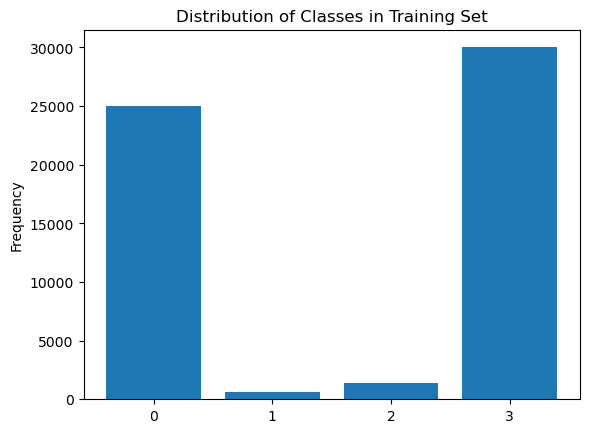

In [17]:
# plot the data distribution in the training set

from tqdm import tqdm
from matplotlib import pyplot as plt

counter = torch.zeros(len(train_set.classes))
for images, labels in tqdm(train_loader):
    for label in labels:
        counter[label] += 1

##########################################################
# **Exercise 4.2.1.2**
# TODO: Plot the distribution of classes in the training set as a bar plot
# https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.bar.html
plt.bar(list(range(len(counter))), counter)
plt.xticks(range(4))
plt.ylabel("Frequency")
plt.title("Distribution of Classes in Training Set")

# raise NotImplementedError

##########################################################

In [18]:
counter / sum(counter)
# ([0.2925, 0.0037, 0.0035, 0.6709, 0.0051, 0.0242])

tensor([0.4384, 0.0108, 0.0239, 0.5270])

In [19]:
weight = max(counter) / counter
weight
# weight + torch.ones(weight.shape)
# 2.7960e+00, 2.0886e+03, 1.4919e+02, 1.0000e+00, 7.7643e+01, 3.8678e+01

tensor([ 1.2021, 48.8811, 22.0846,  1.0000])

In [20]:
(max(counter) / counter) ** .5

tensor([1.0964, 6.9915, 4.6994, 1.0000])

In [21]:
(max(counter) / counter) ** .25

tensor([1.0471, 2.6441, 2.1678, 1.0000])

In [22]:
torch.manual_seed(4440)

# model = cnn_classifier().to(device)
epochs = 75  # your model should be able to get > 98% validation accuracy on the first 10 epochs
####################################################################
# **Exercise 4.2.2.2**
# TODO: choose values for your hyperparameters
learning_rate = 0.0001 #0.005 # None
weight_decay = 0.0005 # None
# TODO: choose a loss function and optimizer
loss_fn = torch.nn.CrossEntropyLoss(weight = ((max(counter) / counter) ** .5).to(device)) #None
# loss_fn = torch.nn.CrossEntropyLoss() #None
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay) # None
milestones = [5, 20, 40, 70]
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones, gamma=0.1)

####################################################################

training_losses = []
validation_losses = []

for epoch in range(epochs):
    lr = 0
    for param_group in optimizer.param_groups:
        lr = param_group['lr']
    start_time = time.perf_counter()
    train_loss, train_acc = train_model(model, train_loader, loss_fn, optimizer)
    training_losses.append(train_loss)
    val_loss, val_acc = evaluate_model(model, val_loader, loss_fn)
    validation_losses.append(val_loss)
    scheduler.step()
    end_time = time.perf_counter()
    print(
        f"epoch: {epoch+1}/{epochs} | train loss={np.mean(train_loss):.4f}, {train_acc=:.4f} | val loss: {np.mean(val_loss):.4f}, {val_acc=:.4f} | time: {end_time-start_time:.4f} | lr: {lr}"
    )
    

epoch: 1/75 | train loss=0.7768, train_acc=0.7977 | val loss: 0.8203, val_acc=0.7220 | time: 144.4559 | lr: 0.0001
epoch: 2/75 | train loss=0.6048, train_acc=0.8505 | val loss: 0.6003, val_acc=0.8389 | time: 142.7017 | lr: 0.0001
epoch: 3/75 | train loss=0.5464, train_acc=0.8594 | val loss: 0.5362, val_acc=0.8455 | time: 141.9971 | lr: 0.0001
epoch: 4/75 | train loss=0.5144, train_acc=0.8631 | val loss: 0.5538, val_acc=0.8488 | time: 141.5599 | lr: 0.0001
epoch: 5/75 | train loss=0.4853, train_acc=0.8683 | val loss: 0.5419, val_acc=0.8836 | time: 142.1122 | lr: 0.0001
epoch: 6/75 | train loss=0.4415, train_acc=0.8764 | val loss: 0.4565, val_acc=0.8784 | time: 142.1984 | lr: 1e-05
epoch: 7/75 | train loss=0.4289, train_acc=0.8800 | val loss: 0.4534, val_acc=0.8752 | time: 142.3529 | lr: 1e-05
epoch: 8/75 | train loss=0.4227, train_acc=0.8811 | val loss: 0.4490, val_acc=0.8843 | time: 143.2088 | lr: 1e-05
epoch: 9/75 | train loss=0.4198, train_acc=0.8811 | val loss: 0.4408, val_acc=0.882

In [44]:
# for name, param in model.named_parameters():
#     print(name, param.shape, param)

In [23]:
torch.save(model.state_dict(), "weights5")

# weights 4 was with lr milestons and wd = 0.005

In [44]:
# model1 = model()
# model1.load_state_dict(torch.load("weights"))

In [47]:
len(training_losses)

20

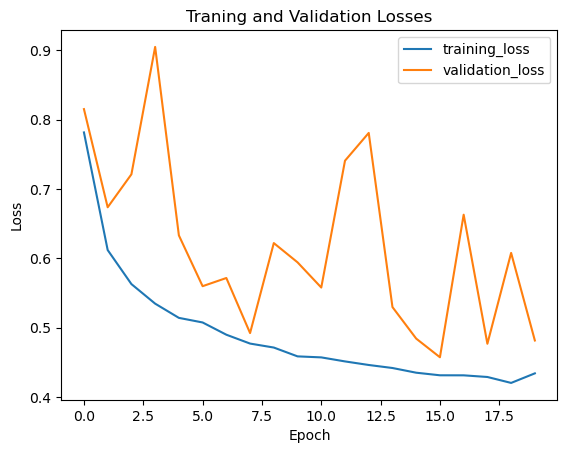

In [48]:
####################################################################
# **Exercise 4.2.2.3**
# TODO: Plot the training and validation losses vs. training epochs on the same plot
# https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.plot.html

plt.plot(range(epochs), training_losses, label="training_loss")
plt.plot(range(epochs), validation_losses, label="validation_loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Traning and Validation Losses")
plt.legend()

#raise NotImplementedError
####################################################################

In [49]:
def draw_confusion_matrix(confusion_matrix, labels, cmap="Blues"):
    confusion_matrix = np.array(confusion_matrix)
    assert confusion_matrix.shape[0] == confusion_matrix.shape[1]
    assert confusion_matrix.shape[0] == len(labels)

    fig, ax = plt.subplots(figsize=(7, 7))
    plt.imshow(confusion_matrix, cmap=cmap)

    ax.set_xticks(np.arange(len(train_set.classes)), labels)
    ax.set_yticks(np.arange(len(train_set.classes)), labels)
    plt.setp(ax.get_xticklabels(), rotation=90, ha="right")

    for true_label in range(len(train_set.classes)):
        for pred_label in range(len(train_set.classes)):
            ax.text(
                pred_label,
                true_label,
                int(confusion_matrix[true_label, pred_label]),
                ha="center",
                va="center",
                color="black",
            )

    fig.tight_layout()
    plt.show()

val_loss=0.4847611742360251, val_acc=0.8720501474926253


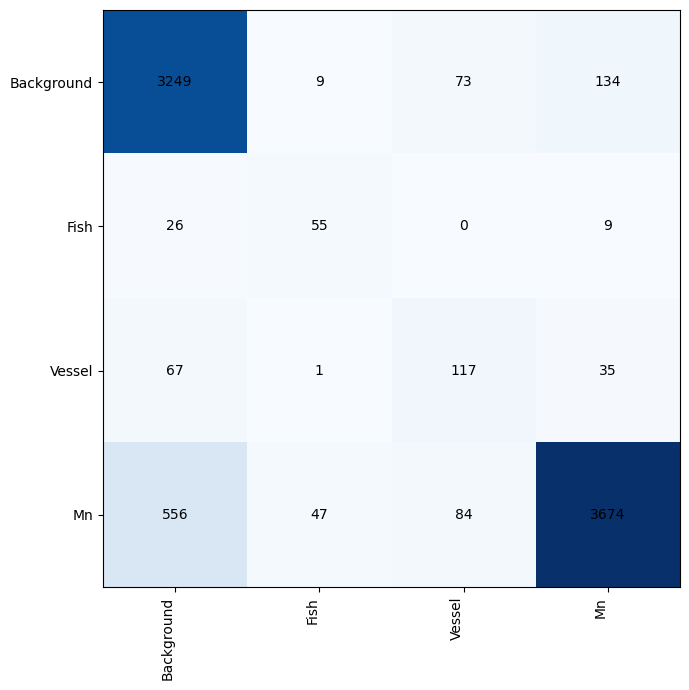

In [50]:
val_loss, val_acc, confusion_matrix = evaluate_model(
    model, val_loader, loss_fn, return_confusion_matrix=True
)
print(f"{val_loss=}, {val_acc=}")
draw_confusion_matrix(confusion_matrix, train_set.classes)

train_loss=0.46522412350127745, train_acc=0.871334761386382


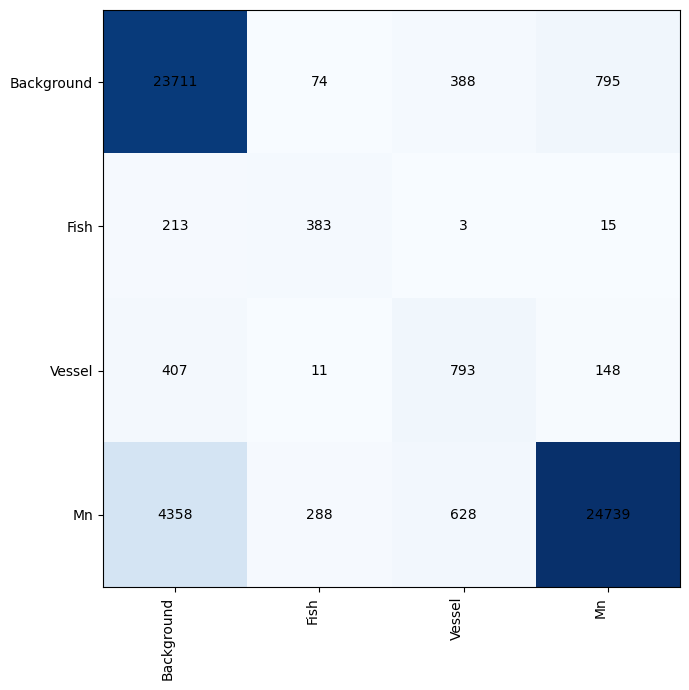

In [51]:
train_loss, train_acc, confusion_matrix = evaluate_model(
    model, train_loader, loss_fn, return_confusion_matrix=True
)
print(f"{train_loss=}, {train_acc=}")
draw_confusion_matrix(confusion_matrix, train_set.classes)

train_loss=0.4622198182802934, train_acc=0.8712996453278085


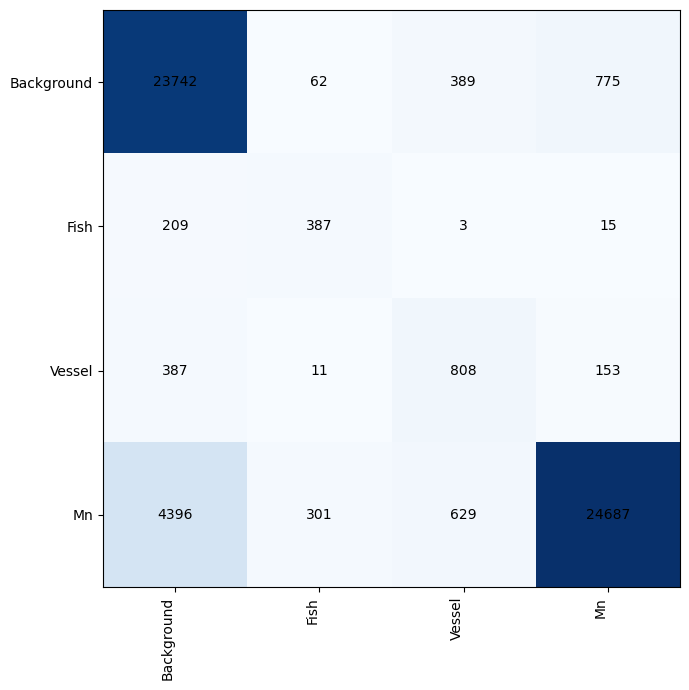

In [52]:
train_loss, train_acc, confusion_matrix = evaluate_model(
    model, train_loader, loss_fn, return_confusion_matrix=True
)
print(f"{train_loss=}, {train_acc=}")
draw_confusion_matrix(confusion_matrix, train_set.classes)